<span style="font-size: 14pt">YEREVAN, May-June 2017</span>

<span style="font-size: 16pt"> HW #5: ARIMA model

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>


<h1 align="center"> Home Work 5 </h1>
** Realize following composions for adaptive algorithms (ESM): Adaptive Selection and Adaptive Composition.**

Start with the code below

In [3]:
import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math
import pandas.tseries.offsets as ofs
from scipy import stats
import statsmodels.api as sm

import warnings as w
import plotly.plotly as py
from IPython.display import Image

%matplotlib inline

/home/daniel/.local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
def AdaptiveExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    gamma = Params['gamma']
    AdaptationPeriod=Params['AdaptationPeriod']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = np.NaN
    t0= np.NaN
    e1= np.NaN
    e2= np.NaN
    Kt_1 = alpha
    K=alpha
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(y):
                y=x[t]
                t0=t
                e1=alpha
                e2 = 1
            else:
                if (t-t0)<h:
                    e1 = gamma*(x[t]-y)+(1-gamma)*e1
                    e2 = gamma*np.abs(x[t]-y)+(1-gamma)*e2
                else:
                    e1 = gamma*(x[t]-FORECAST[t])+(1-gamma)*e1
                    e2 = gamma*np.abs(x[t]-FORECAST[t])+(1-gamma)*e2
            
            if e2==0:
                K=alpha
            else:
                K=np.abs(e1/e2)

            alpha=Kt_1
            Kt_1=K

            if (t-t0+1)<AdaptationPeriod:
                y = y*(1-alpha)*(t-t0+1)/(AdaptationPeriod) + (1-(1-alpha)*(t-t0+1)/(AdaptationPeriod))*x[t]
            else:
                y = y*(1-alpha) + (alpha)*x[t]
        FORECAST[t+h] = y
    return FORECAST

def SimpleExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = x[0]
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(y):
                y=x[cntr]
            y = y*(1-alpha) + alpha*x[cntr]
            #else do not nothing
        FORECAST[cntr+h] = y
    return FORECAST

def qualityMACAPE(x,y):
    qlt = (2*(x-y)/(x+y)).abs().replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , (x-y).abs()

def qualityRMSE(x,y):
    return (((x-y)**2).mean())**(0.5) , (x-y)**2

In [23]:
def AdaptiveSelection(x, h, Params):
    '''
    Parameters
    x <array> - time series
    h <integer scalar>- forecasting delay
    Params <dict> - dictionary with 
        gamma <scalar in [0,1]> - smoothing parameter of error
        eps <scalar> - bound for best indistinctive models
        BaseAlgs - array of <dict> with params
            BaseAlg <string> - name of base algorithm
            BaseAlfParams <dict> dictionary of base algorithm's params
    '''
    T = len(x)
    FORECAST = [np.NaN]*(T+h)

    
    
    # Base Algs Forecasts     
    BaseAlgs = Params['BaseAlgsParams']
    N = len(BaseAlgs)
    FORECAST_BA = np.array([np.NAN]*(T+h)*N).reshape(N, T+h)
    
    
    #     forecast TS by each base algs
    #     be careful with eval() function    
    for ba in range(N):
        FORECAST_BA[ba]= eval(BaseAlgs[ba]['BaseAlg']+"(x,h,"+"BaseAlgs["+str(ba)+"]['BaseAlgParams'])")
        
        
        
        
    # internal params of composition
    gamma = Params['gamma']
    eps = Params['eps']
    
    if gamma>1:
        w.warn('Gamma can not be more than 1')
        #alpha = 1
        return FORECAST
    if gamma<0:
        w.warn('Gamma can not be less than 0')
        #alpha = 0
        return FORECAST

    
    e1= np.zeros(N)  # initialization of errors of base algorithms 
    j_best = 0
    
    y=1.5
        
    for t in range(0, T):
        if not math.isnan(x[t]):
            
            if t>= h:
                'TODO: check this code'
                e1 = gamma*np.abs(x[t]-FORECAST_BA.transpose()[t])+(1-gamma)*e1
                if np.isnan(e1.sum()):
                    e1=np.zeros(N)
                # select best algorithm at the moment t
                j_best = np.argmin(e1)#'TODO: find index of best base alg'
                # select best indistinctive
                idx_bestinsdistinctive =[]
                for i in range(N):
                    if abs(e1[i]-e1[j_best])<eps:
                        idx_bestinsdistinctive.append(i)# 'TODO: find indexes of best indistinctive algorithms'
                
                y = FORECAST_BA.transpose()[t,idx_bestinsdistinctive].mean()
                # else do nothing
#         else do nothing
            
            
        FORECAST[t+h] = y
    return FORECAST

In [19]:
def AdaptiveComposition(x, h, Params):
    '''
    Parameters
    x <array> - time series
    h <integer scalar>- forecasting delay
    Params <dict> - dictionary with 
        gamma <scalar in [0,1]> - smoothing parameter of error
        BaseAlgs - array of <dict> with params
            BaseAlg <string> - name of base algorithm
            BaseAlfParams <dict> dictionary of base algorithm's params
    '''
    T = len(x)
    FORECAST = [np.NaN]*(T+h)

    
    
    # Base Algs Forecasts     
    BaseAlgs = Params['BaseAlgsParams']
    N = len(BaseAlgs)
    FORECAST_BA = np.array([np.NAN]*(T+h)*N).reshape(N, T+h)
    
    
    #     forecast TS by each base algs
    #     be careful with eval() function    
    for ba in range(len(BaseAlgs)):
        FORECAST_BA[ba]= eval(BaseAlgs[ba]['BaseAlg']+"(x,h,"+"BaseAlgs["+str(ba)+"]['BaseAlgParams'])")
    
    # internal params of composition
    gamma = Params['gamma']
    
    if gamma>1:
        w.warn('Gamma can not be more than 1')
        #alpha = 1
        return FORECAST
    if gamma<0:
        w.warn('Gamma can not be less than 0')
        #alpha = 0
        return FORECAST

    
    e1= np.zeros(N)  # initialization of errors of base algorithms 
    weights = np.zeros(N)
    
    y=1.5
    
    for t in range(0, T):
        if not math.isnan(x[t]):
            
            if t>= h:
                e1 = gamma*np.abs(x[t]-FORECAST_BA.transpose()[t])+(1-gamma)*e1
                if np.isnan(e1.sum()):
                    e1=np.zeros(N)

                weights = e1/e1.sum()
                
#               Calculate forecast of the composition
                y = FORECAST_BA.transpose()[t].dot(weights)
                # else do nothing
#         else do nothing
            
            
        FORECAST[t+h] = y
    return FORECAST

In [7]:
BaseAlgs = [{'BaseAlg':'SimpleExponentialSmoothing', 'BaseAlgParams':{'alpha':0.1, 'AdaptationPeriod':10}},
            {'BaseAlg':'AdaptiveExponentialSmoothing', 'BaseAlgParams':{'alpha':0.2,'gamma':0.01, 'AdaptationPeriod':10}}
#                  {'BaseAlg':'AdaptiveSimpleExponentialSmoothing', 'BaseAlgParams':{'alpha':0.1, 'gamma':0.01}},
#                 {'BaseAlg':'TheilWageSmoothing', 'BaseAlgParams':{'alpha':0.3, 'beta':0.9,'delta':0.9}}
]

In [8]:
for ba in range(len(BaseAlgs)):
    print(BaseAlgs[ba]['BaseAlg']+"(x,h,"+"BaseAlgs["+str(ba)+"]['BaseAlgsParams'])")

SimpleExponentialSmoothing(x,h,BaseAlgs[0]['BaseAlgsParams'])
AdaptiveExponentialSmoothing(x,h,BaseAlgs[1]['BaseAlgsParams'])


In [35]:
ts = pd.read_csv('TimeSeries_Data10.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Dates')
ts.index.names=['Timestamp']
# ts = pd.read_csv('./data/TimeSeries_Data10.csv', sep=',', decimal='.')
ts = ts.sort_index() # sort index

In [12]:
h =1 
frc_ts = pd.DataFrame(index = ts.index.append(pd.date_range(ts.index[-1]+timedelta(1), ts.index[-1]+timedelta(h)))
                      , columns = ts.columns)

FRC_TS = dict()

In [13]:
for cntr in ts.columns:
    frc_ts1[cntr]= AdaptiveExponentialSmoothing(ts[cntr],h, {'alpha':0.1,'gamma':0.01,  'AdaptationPeriod':10})

# ADAPTIVE SELECTION

In [36]:
# run Adaptive Selection
gamma=0.01
eps = 1.0

for cntr in ts.columns:
    frc_ts[cntr]= AdaptiveSelection(ts[cntr],h, {'gamma':gamma, 'eps': eps, 'BaseAlgsParams':BaseAlgs})
FRC_TS['AS gamma %.2f eps %.2f' % (gamma, eps)] = frc_ts

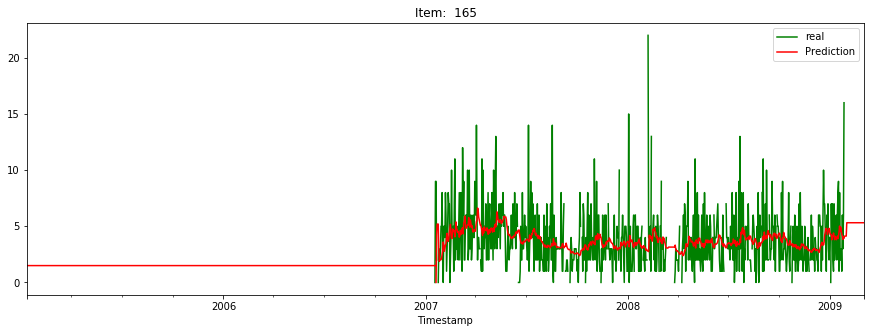

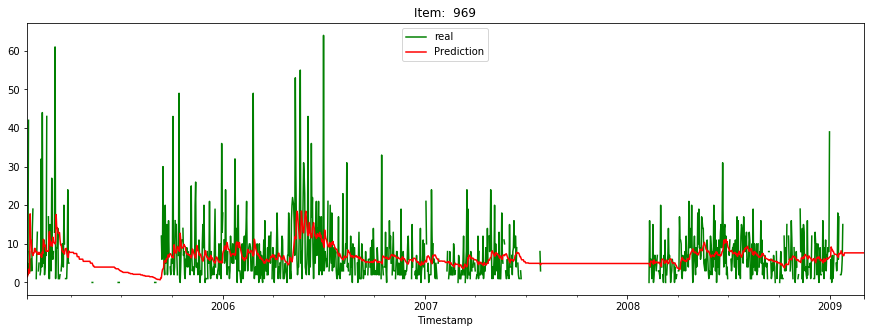

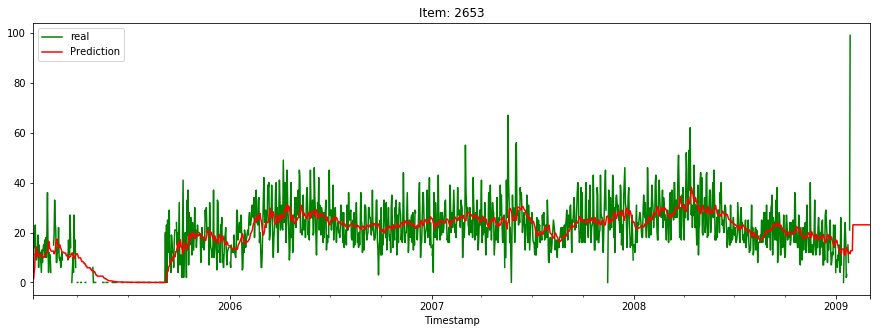

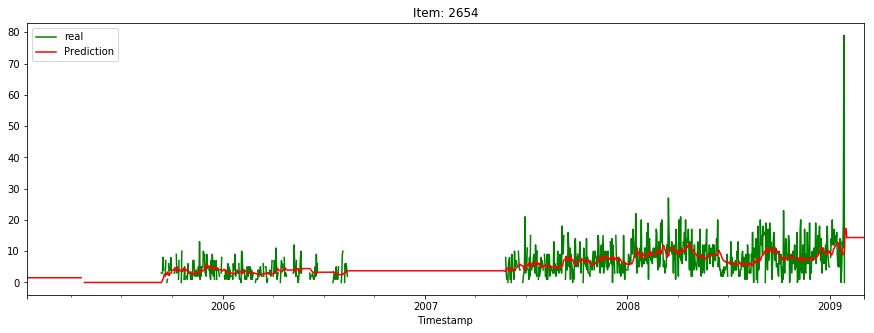

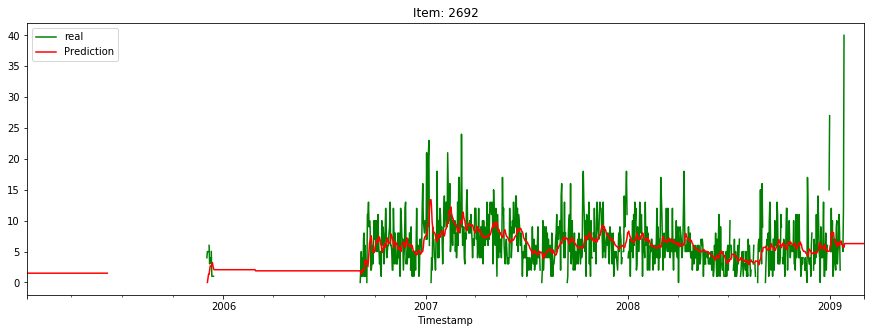

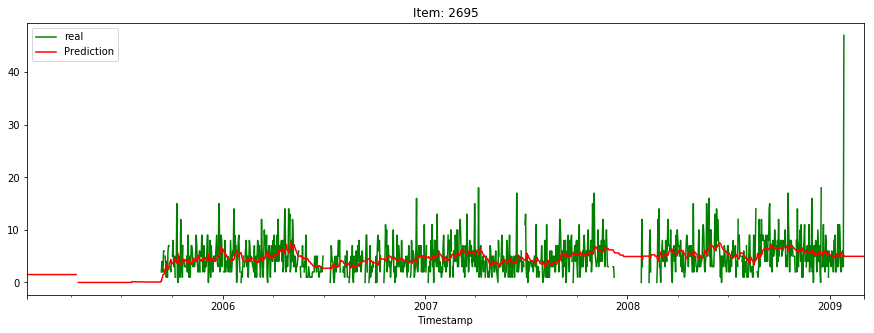

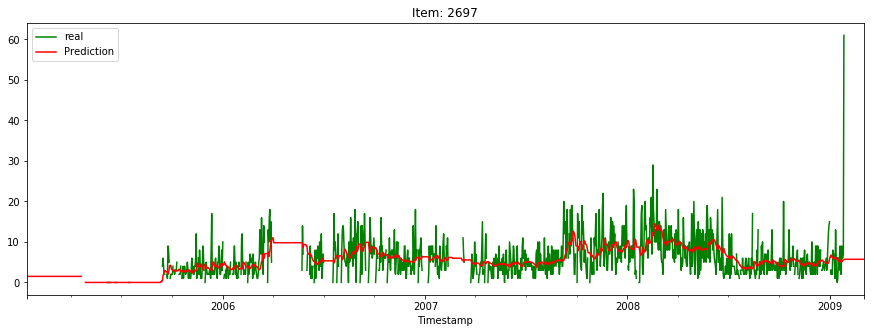

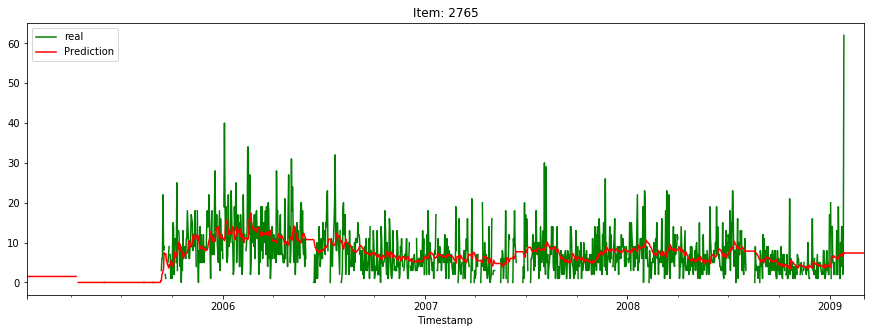

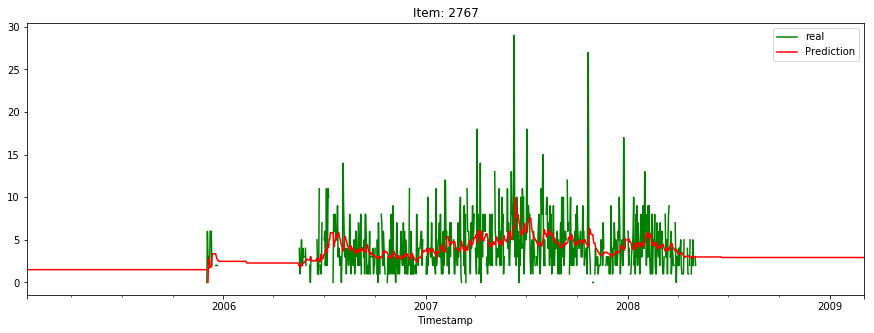

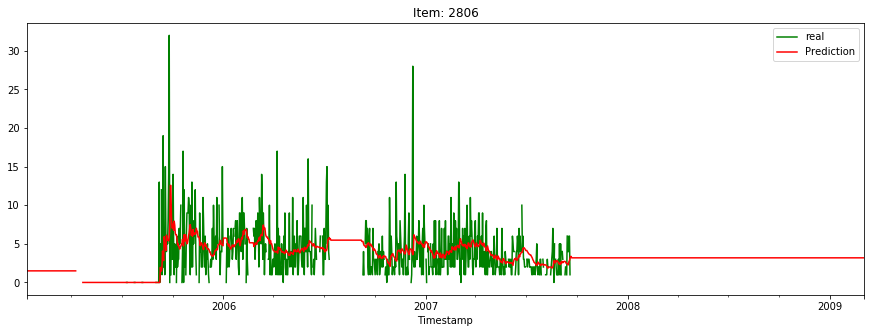

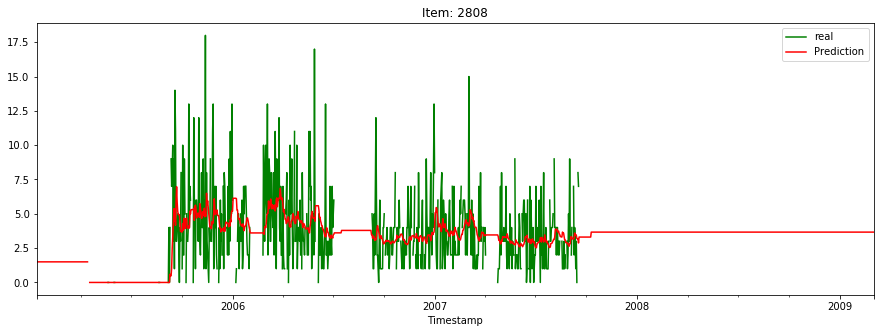

In [42]:
for col in ts.columns:
    ts[col].plot(figsize=(15,5), color='green', label='real')
    frc_ts[col].plot(color='red', label='Prediction')
    plt.title(col)
    plt.legend()
    plt.show()


# ADAPTIVE COMPOSITION

In [43]:
# run Adaptive Composition
gamma=0.01

for cntr in ts.columns:
    frc_ts[cntr]= AdaptiveComposition(ts[cntr],h, {'gamma':gamma, 'BaseAlgsParams':BaseAlgs})
FRC_TS['AC gamma %.2f' % (gamma)] = frc_ts

/home/daniel/.local/lib/python2.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning:

invalid value encountered in divide



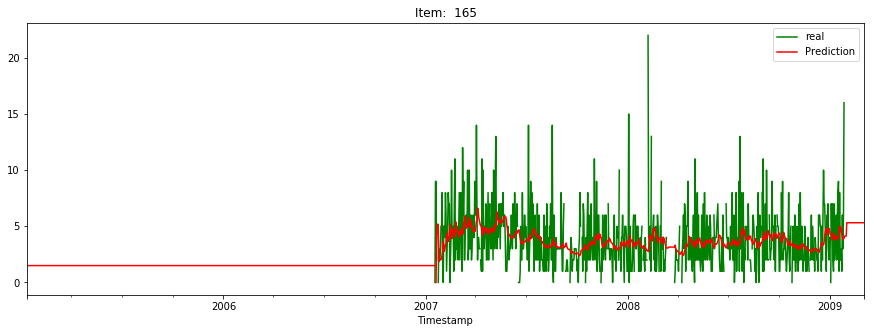

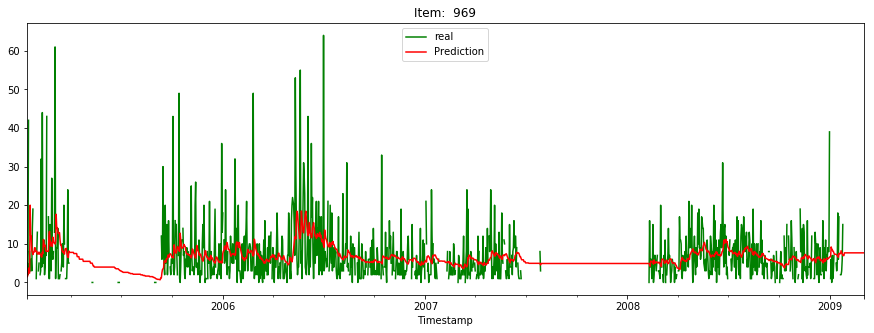

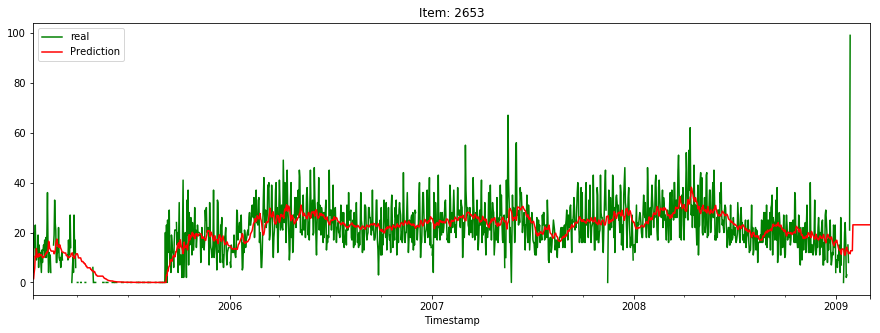

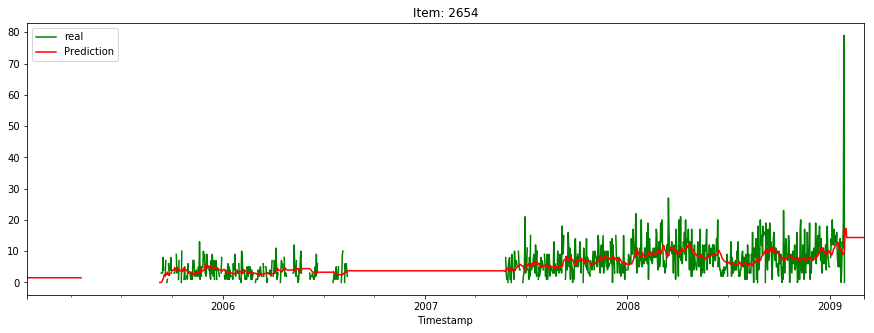

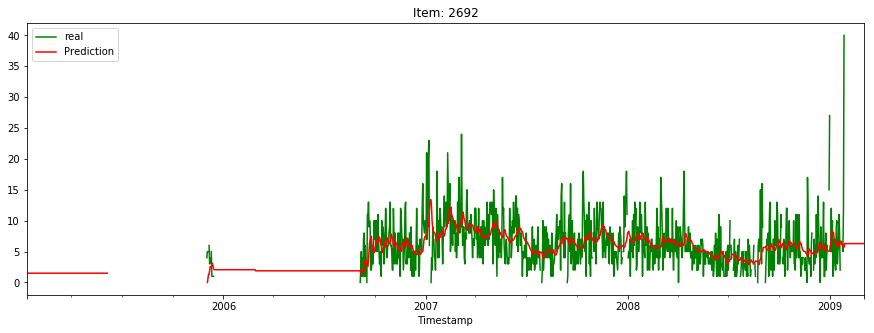

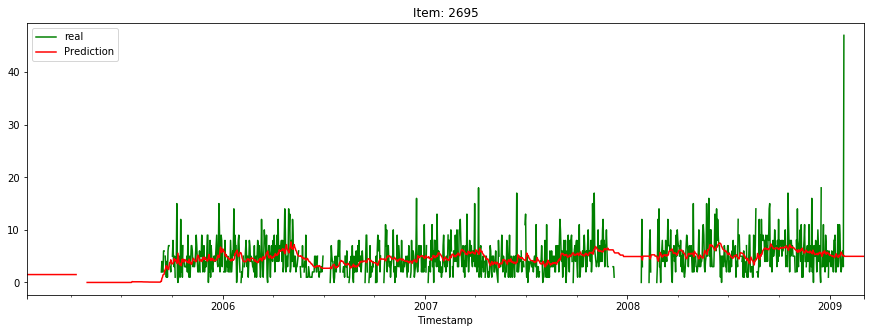

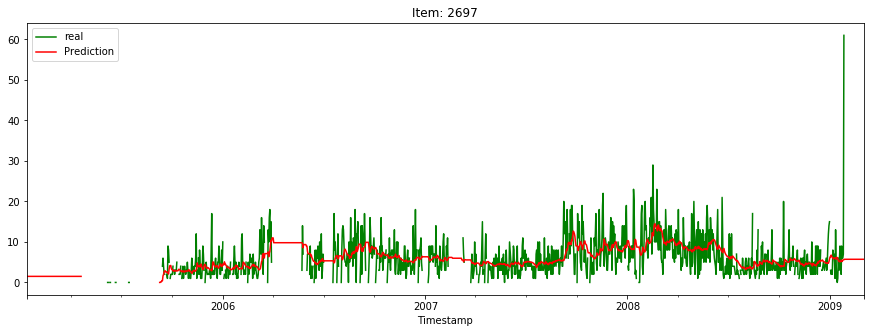

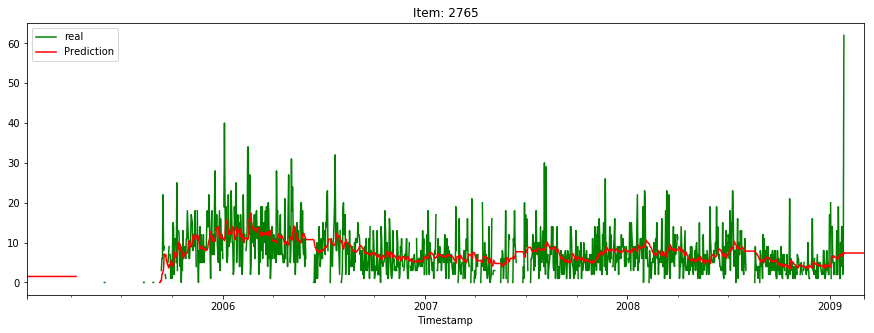

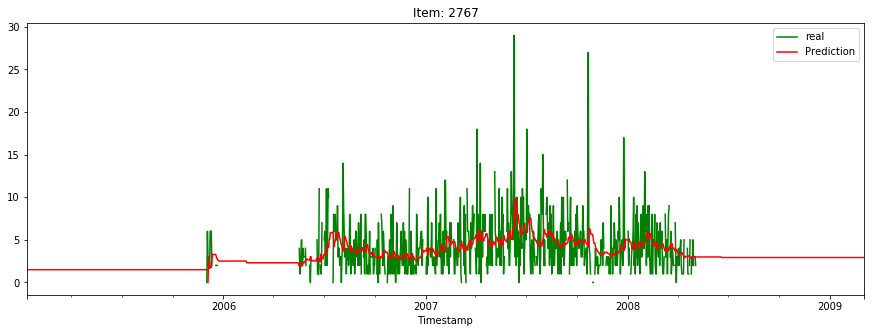

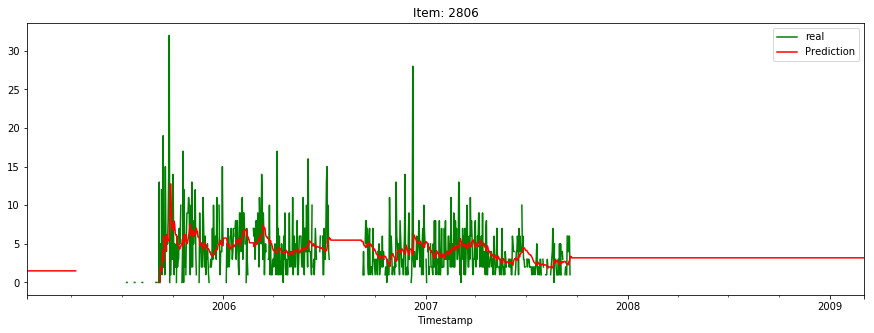

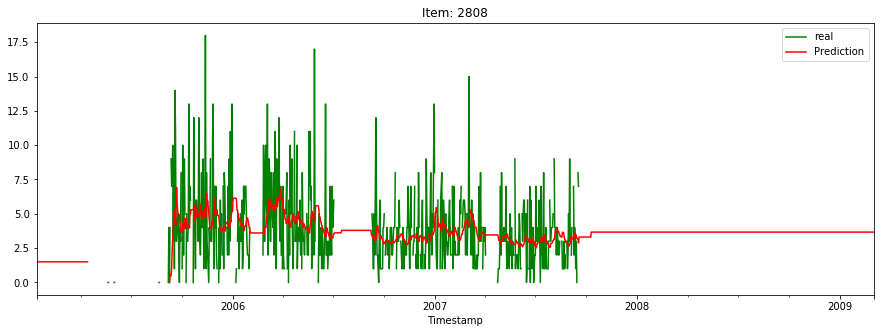

In [44]:
for col in ts.columns:
    ts[col].plot(figsize=(15,5), color='green', label='real')
    frc_ts[col].plot(color='red', label='Prediction')
    plt.title(col)
    plt.legend()
    plt.show()

/home/daniel/.local/lib/python2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



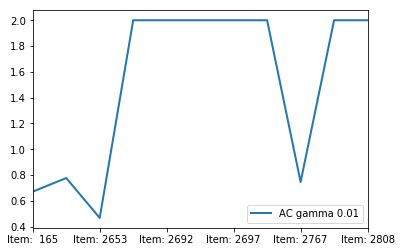

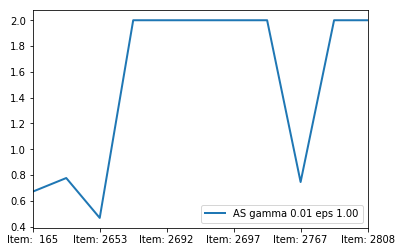

           AC gamma 0.01
Item:  165      0.672071
Item:  969      0.777411
Item: 2653      0.468329
Item: 2654             2
Item: 2692             2
Item: 2695             2
Item: 2697             2
Item: 2765             2
Item: 2767      0.746416
Item: 2806             2
Item: 2808             2


In [45]:
# plot loss of compositions
ix = range(100)
# compare ES methods in first 100 steps
QualityStr = pd.DataFrame(index = ts.columns, columns = sorted(FRC_TS.keys()))

for model in QualityStr.columns:
    frc_ts = FRC_TS[model]
    for ts_num in ts.columns:
        ix = pd.date_range(ts[ts_num].first_valid_index(), ts[ts_num].first_valid_index()+timedelta(50))
        QualityStr[model][ts_num],_ = qualityMACAPE(ts[ts_num].ix[ix], frc_ts[ts_num].ix[ix])

QualityStr[sorted(QualityStr.columns)[:1]].plot(label='AdaptiveComposition', linewidth=2.0)
QualityStr[sorted(QualityStr.columns)[1:2]].plot(label='AdaptiveSelection', linewidth=2.0)

plt.legend()
plt.show()

print(QualityStr[sorted(QualityStr.columns)[:1]])